In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pandas.core.common import SettingWithCopyWarning
import warnings
train_df = pd.read_csv('../data_file/fill_na_train.csv')
test_df = pd.read_csv('../data_file/fill_na_test.csv')

In [6]:
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

In [7]:
train_df.groupby('building_number').total_area.mean().sort_values()

building_number
13    5.578400e+03
36    8.816490e+03
35    9.736000e+03
34    1.066500e+04
58    1.489700e+04
          ...     
25    5.280141e+05
27    5.784841e+05
24    6.596969e+05
61    6.671310e+05
20    1.287288e+07
Name: total_area, Length: 100, dtype: float64

In [8]:
train_df['date_time'] = pd.to_datetime(train_df['date_time'])
train_df.set_index('date_time', inplace=True)

In [9]:
from datetime import datetime
from statsmodels.tsa.seasonal import seasonal_decompose

data_grouped = train_df.groupby('building_number').resample('H').mean()

In [10]:
train_df.reset_index(inplace=True)

In [11]:
def z_score_method(series ,lower_threshold = 1.5, upper_threshold=1.5):
    """
    Apply the Z-score method for anomaly detection
    
    Args:
    series: Time series data
    threshold: Z-score threshold for anomaly detection. Defaults to 3.
    
    Returns:
    An array containing the indices of the anomalies
    """
    # Calculate z-scores
    z_scores = (series - series.mean()) / series.std()
    
    # Identify anomalies
    anomalies = np.where((z_scores > lower_threshold) | (z_scores < -upper_threshold))
    
    return anomalies

In [12]:
def plot_residuals(building_index, lower=1.5, upper=2.0):

    decomposition_building = seasonal_decompose(data_grouped.loc[building_index]['power_consumption'], model='additive', period=24)

    # Drop NaN values from residuals
    residuals_building = decomposition_building.trend

    # Calculate the IQR of the residuals
    Q1_resid_building = residuals_building.quantile(0.25)
    Q3_resid_building = residuals_building.quantile(0.75)
    IQR_resid_building = Q3_resid_building - Q1_resid_building

    # Define the thresholds for outliers
    lower_threshold_resid_building = Q1_resid_building - lower * IQR_resid_building
    upper_threshold_resid_building = Q3_resid_building + upper * IQR_resid_building

    # Identify the outliers
    outliers_resid_building = residuals_building[(residuals_building < lower_threshold_resid_building) | 
                                                     (residuals_building > upper_threshold_resid_building)]

    # Convert the outliers' indices to match the original data's indices
    outliers_resid_indices_building = data_grouped.loc[building_index].index[data_grouped.loc[building_index].index.isin(outliers_resid_building.index)]

    # Get the corresponding 'power_consumption' values for these indices
    outliers_resid_original_building = data_grouped.loc[building_index, 'power_consumption'].loc[outliers_resid_indices_building]

    # Plot the original data and the outliers
    plt.figure(figsize=(12,6))
    plt.plot(data_grouped.loc[building_index]['power_consumption'], label='Original')
    plt.scatter(outliers_resid_original_building.index, outliers_resid_original_building, color='red', label='Outliers')
    plt.legend(loc='best')
    plt.title(f'Power Consumption for Building Number {building_index} with Outliers of Residuals')
    plt.show()

In [13]:
def plot_trend(building_index, lower=1.8, upper=2.5):
    data_building = train_df[train_df['building_number'] == building_index]

    # Set date_time as the index
    data_building.set_index('date_time', inplace=True)

    # Apply seasonal decomposition
    decomposition = seasonal_decompose(data_building['power_consumption'], model='additive', period=24)

    # Apply Z-score method to trend
    trend = decomposition.trend.dropna()  # Remove missing values
    anomalies_trend = z_score_method(trend, lower, upper)

    # Print number of anomalies detected
    print(f"Number of anomalies detected in trend: {len(anomalies_trend[0])}")

    # Plot power consumption over time, highlighting anomalies
    plt.figure(figsize=(15, 8))
    plt.plot(data_building.index, data_building['power_consumption'], label='Power consumption')
    plt.scatter(trend.index[anomalies_trend], data_building['power_consumption'].loc[trend.index[anomalies_trend]], color='red', label='Anomalies')
    plt.title('Power Consumption Over Time (Building 17)')
    plt.xlabel('Time')
    plt.ylabel('Power Consumption')
    plt.legend()
    plt.show()

# isolationforest 이용하기

- isolate한 점 찾기
- 찾아서 다른 값으로 채우기
- 학습된 값
- 주변값

In [14]:
from sklearn.ensemble import IsolationForest


def find_isolate(building_number, upper_contamin = 0.001, lower_contamin=0.02):
# Filter the dataset for building number 1

    data_building = train_df[train_df['building_number'] == building_number]
    
    # power conumpotion 평균계산
    avg_pwr = data_building['power_consumption'].mean()

    # Create an instance of IsolationForest
    upper_iso_forest = IsolationForest(contamination=upper_contamin, random_state=42)  # contamination parameter determines the proportion of outliers in the dataset
    upper_iso_forest.fit(data_building[['power_consumption']])

    lower_iso_forest = IsolationForest(contamination=lower_contamin, random_state=42)  # contamination parameter determines the proportion of outliers in the dataset
    lower_iso_forest.fit(data_building[['power_consumption']])
    
    
    data_building['upper_outliers'] = upper_iso_forest.predict(data_building[['power_consumption']])
    data_building['lower_outliers'] = lower_iso_forest.predict(data_building[['power_consumption']])
    
    data_building['outliers'] = data_building['power_consumption']
    
    data_building.loc[data_building['power_consumption'] >= avg_pwr, 'outliers'] = data_building[data_building['power_consumption'] >= avg_pwr]['upper_outliers']
    data_building.loc[data_building['power_consumption'] < avg_pwr, 'outliers'] = data_building[data_building['power_consumption'] < avg_pwr]['lower_outliers']
    
    data_building['anomaly'] = data_building['outliers'] == -1
     
    
    
    # without anomaly detection 
    fig, ax = plt.subplots(2, 1, figsize=(15,12))
    ax[0].plot_date(data_building['date_time'], data_building['power_consumption'], '-', color='b', label='inliers')
    ax[0].scatter(data_building[data_building['outliers'] == -1].date_time, data_building[data_building['outliers'] == -1]['power_consumption'], color='r', label='outliers')
    ax[0].set_title('Power Consumption Outliers in Building ')
    ax[0].set_xlabel('Date Time')
    ax[0].set_ylabel('Power Consumption')
    ax[0].legend()
    ax[0].grid(True)
    
    ax[1].plot_date(data_building['date_time'][data_building['anomaly'] == False], data_building['power_consumption'][data_building['anomaly'] == False], '-', label='Normal')
    ax[1].plot_date(data_building['date_time'][data_building['anomaly'] == True], data_building['power_consumption'][data_building['anomaly'] == True], 'r.', label='Anomaly')
    ax[1].set_title(f'Power Consumption of Building No.{building_number} Over Time without Anomalies')
    ax[1].set_xlabel('Date Time')
    ax[1].set_ylabel('Power Consumption')
    ax[1].legend()
    ax[1].grid(True)
    
    plt.tight_layout()
    plt.show()
    

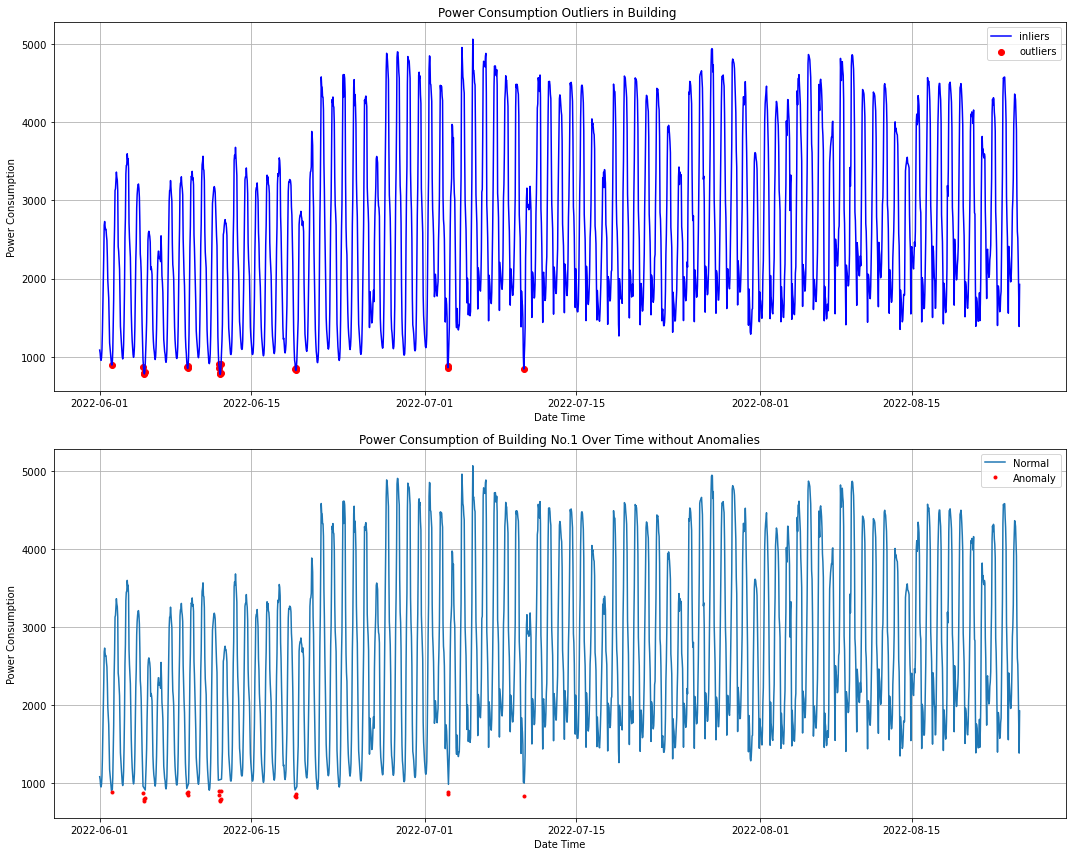

In [15]:
find_isolate(1)

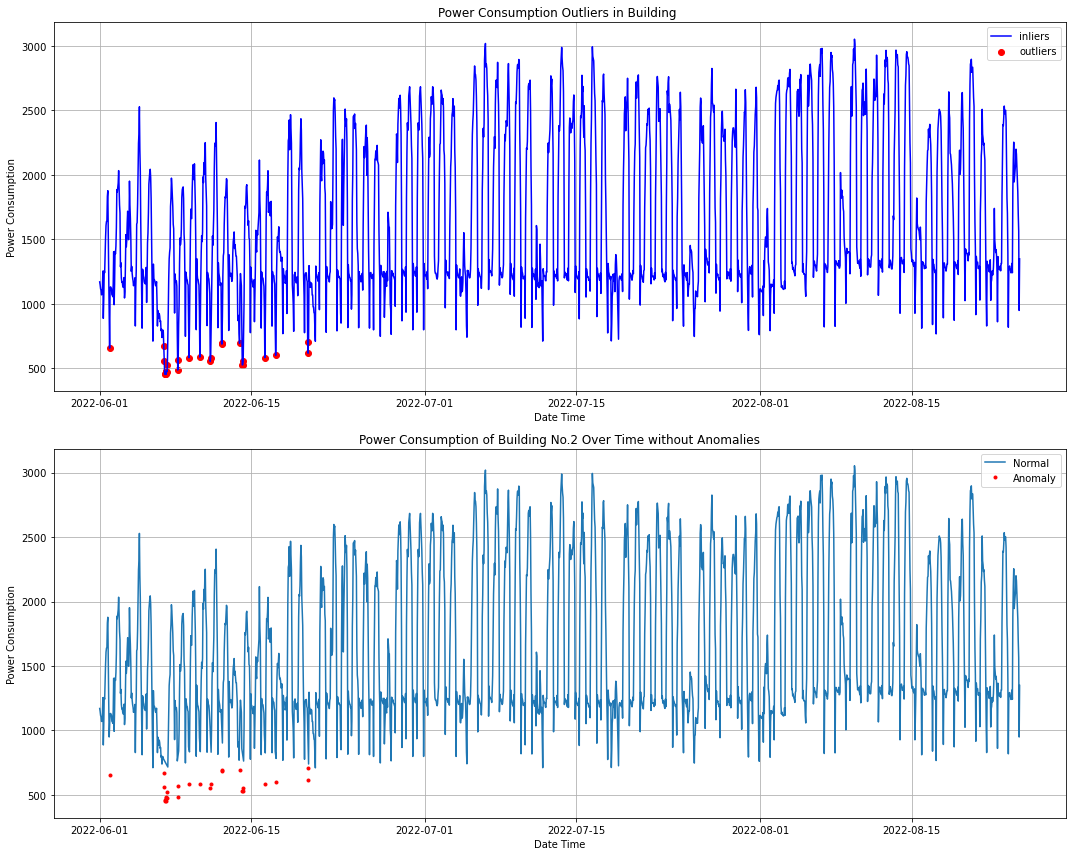

In [89]:
find_isolate(2)

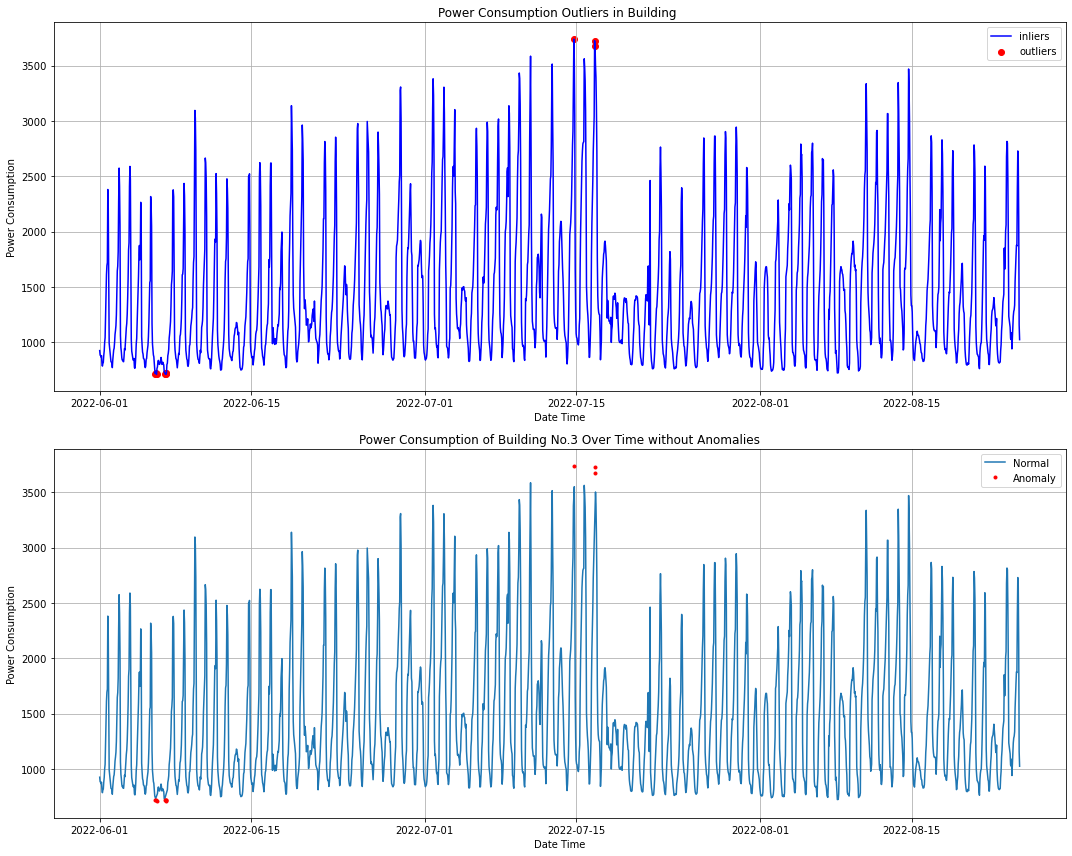

In [91]:
find_isolate(3)

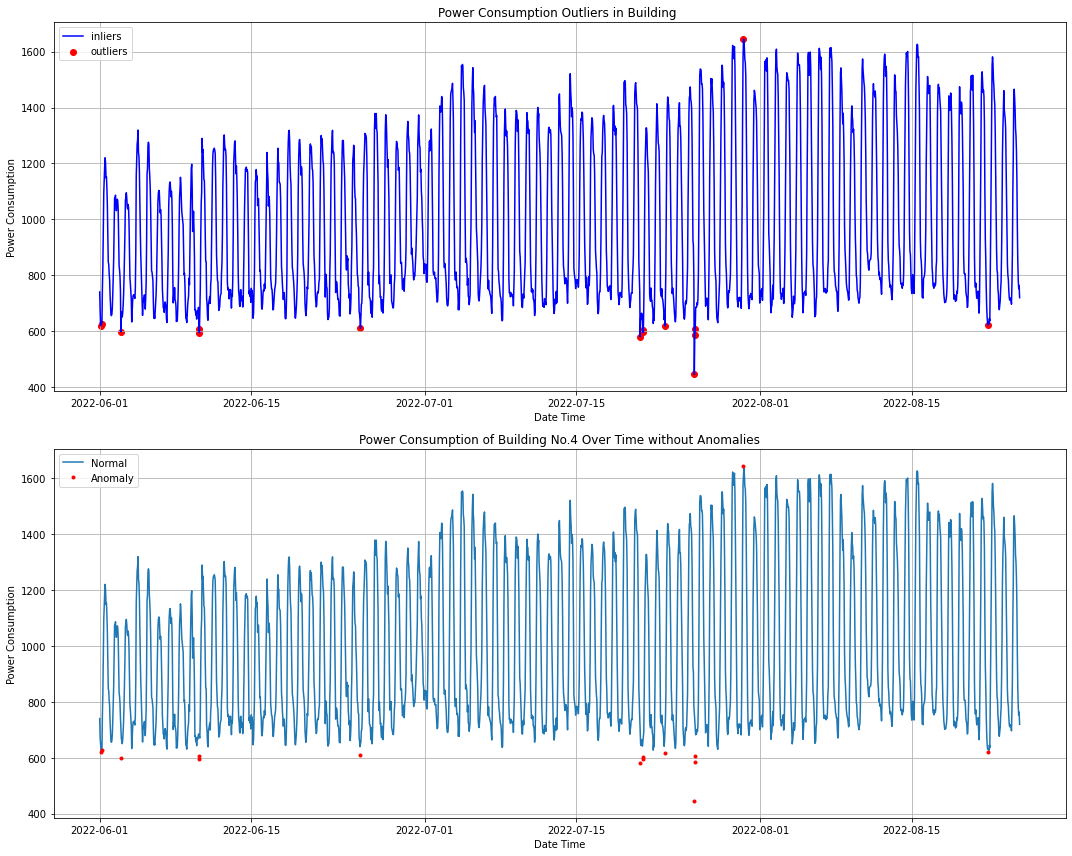

In [92]:
find_isolate(4)

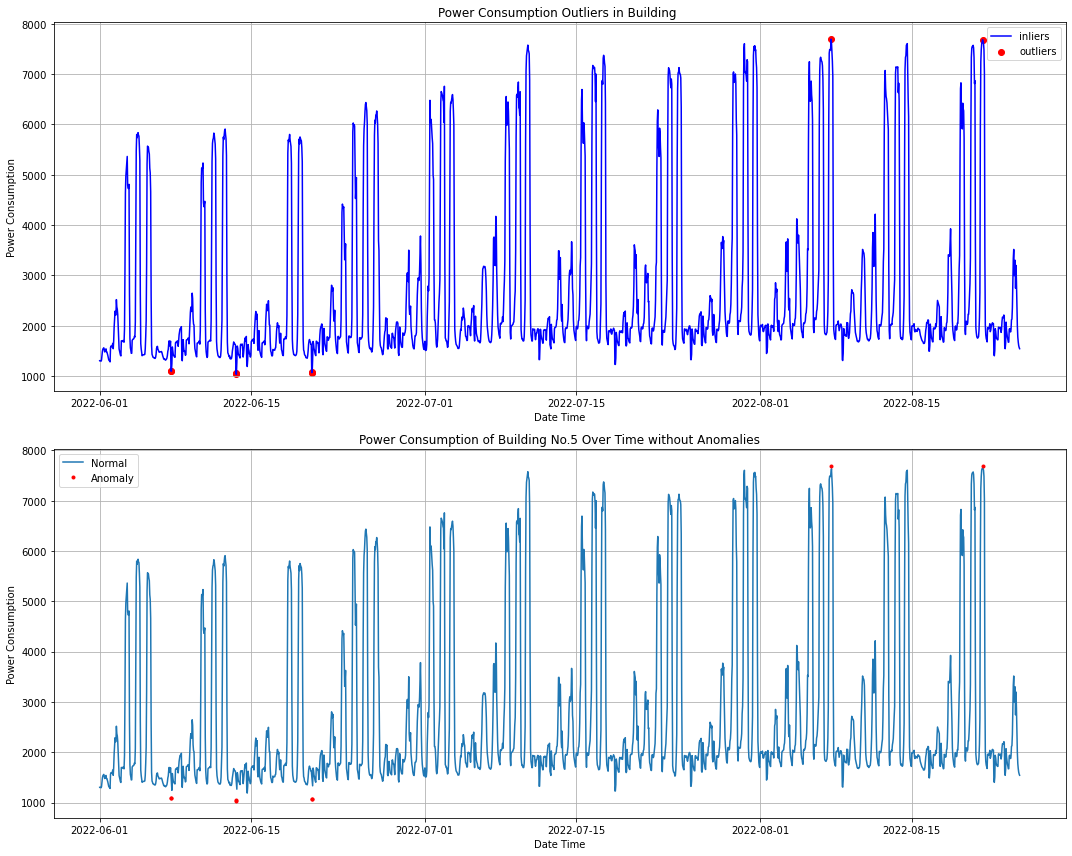

In [93]:
find_isolate(5)

In [ ]:
find_isolate(6)

In [ ]:
find_isolate(7)

In [ ]:
find_isolate(8)

In [ ]:
find_isolate(9)

In [ ]:
find_isolate(10)

In [ ]:
find_isolate(11)

In [ ]:
find_isolate(12)

In [ ]:
find_isolate(13)

In [ ]:
find_isolate(5)

In [ ]:
find_isolate(5)

In [ ]:
find_isolate(5)

In [ ]:
find_isolate(5)

In [ ]:
find_isolate(5)

In [ ]:
find_isolate(5)

In [ ]:
find_isolate(5)

In [ ]:
find_isolate(5)

In [ ]:
find_isolate(5)

In [ ]:
find_isolate(5)

In [ ]:
find_isolate(5)

In [ ]:
find_isolate(5)

In [ ]:
find_isolate(5)

In [ ]:
find_isolate(5)

In [ ]:
find_isolate(5)

In [ ]:
find_isolate(5)

In [ ]:
find_isolate(5)

In [ ]:
find_isolate(5)

In [ ]:
find_isolate(5)

In [ ]:
find_isolate(5)

In [ ]:
find_isolate(5)

In [ ]:
find_isolate(5)

In [ ]:
find_isolate(5)

In [ ]:
find_isolate(5)

In [ ]:
find_isolate(5)

In [ ]:
find_isolate(5)

In [ ]:
find_isolate(5)

In [ ]:
find_isolate(5)

In [ ]:
find_isolate(5)

In [ ]:
find_isolate(5)

In [ ]:
find_isolate(5)

In [ ]:
find_isolate(5)

In [ ]:
find_isolate(5)

In [ ]:
find_isolate(5)

In [ ]:
find_isolate(5)

In [ ]:
find_isolate(5)

In [ ]:
find_isolate(5)

In [ ]:
find_isolate(5)

In [ ]:
find_isolate(5)

In [ ]:
find_isolate(5)

In [ ]:
find_isolate(5)

In [ ]:
find_isolate(5)

In [ ]:
find_isolate(5)

In [ ]:
find_isolate(5)

In [ ]:
find_isolate(5)

In [ ]:
find_isolate(5)

In [ ]:
find_isolate(5)

In [ ]:
find_isolate(5)

In [ ]:
find_isolate(5)

In [ ]:
find_isolate(5)

In [ ]:
find_isolate(5)

In [ ]:
find_isolate(5)

In [ ]:
find_isolate(5)

In [ ]:
find_isolate(5)

In [ ]:
find_isolate(5)

In [ ]:
find_isolate(5)

In [ ]:
find_isolate(5)